# What we show in this notebook
The point of this notebook is to compare scipy's stock 
   * `Nelder-Mead algorithm`,
   * `Differential Evolution` (worst name ever)
   * `Nelder-Mead with Basinhopping`
   
both in terms of computaional cost and their respective convergence. There are two functions to compare with: Matlab's Peaks function and a wild floor fuction found in Price & Stone _Differential Evolution_. Peaks is nice because it has many local minima and maxima using $C^{\infty}$ functions and the floor function is continuous but non-differntiable and is full of small regions of local optimum. 

## results
Basinhopping can behave badly for problem functions. The floor function that appears below causes the basinhopping algorithm to _absolutely go bonkers_. The `differential evolution` does indeed seem to behave the best for the two test cases presented here.  

# Description of the algorithms

## The Nelder--Mead algorithm

The Nelder--Mead algorithm attempts to minimize a goal function $f:\mathbf{R}^n\mapsto \mathbf{R}$ of an unconstrained optimization problem. The Nelder--Mead algorithm is a direct search method: There is no dependence on derivatives! Although the method generally lacks rigorous convergence properties, in practice the first few iterations often yield satisfactory results . Typically, each iteration evaluates the goal function only once or twice , which is why the Nelder--Mead algorithm is comparatively fast if goal function evaluation is the computational bottleneck. But, Nelder-Mead is *very susceptible* to local optima. 

## The algorithm
Nelder & Mead refined a simplex method by Spendley et al. In this context we think of a simplex as a generalization of triangles $n$ dimensions: in $\mathbf{R}^n$, a simplex is the convex hull of $n+1$ vertices $x_0,\ldots,x_n\in\mathbf{R}^n$. Starting with an initial simplex, the algorithm attempts to decrease the function values $f_i:=f(xi)$ at the vertices by a sequence of elementary transformations of the simplex along the local topology. The algorithm succeeds when the simplex is sufficiently small (*domain convergence test*), and/or when the function values fi are sufficiently close (function-value convergence test). The algorithm fails when it did not succeed after a given number of iterations or function evaluations. 

In [290]:
# imports
from numpy import exp,arange
import numpy as np
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from time import time
%matplotlib inline

In [291]:
# Using an array (list) named ps we will keep track
# of the states for parameter optimization
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    ps.append(p)
    
def basin_reporter(x, f, accepted):
    """Reporter function to capture intermediate states of optimization."""
    ps.append(x)
    
def DE_reporter(xk,convergence):
    """Reporter function to capture intermediate states of optimization."""
    ps.append(xk)

# Toy functions
#def z_func(x,y):
#    func = 3.0*(1.0 - x)**2*np.exp(-x**2 - (y+1.0)**2) - \
#    10.0*(x/5.0 - x**3 - y**5)*np.exp(-x**2 - y**2) - 0.33*np.exp(-(x + 1.0)**2 - y**2)
#    return func
    #return np.floor(10.0*(10.0 - np.exp(-x**2 - 3.0*y**2)))/10
def z_fun(x):
    func = 3.0*(1.0 - x[0])**2*np.exp(-x[0]**2 - (x[1]+1.0)**2) - \
    10.0*(x[0]/5.0 - x[0]**3 - x[1]**5)*np.exp(-x[0]**2 - x[1]**2) - \
    0.33*np.exp(-(x[0] + 1.0)**2 - x[1]**2)
    return func 

# for surface plots
x = arange(-4.0,4.0,0.05)
y = arange(-4.0,4.0,0.05)
X,Y = meshgrid(x, y) # grid of point
Z = z_fun([X, Y])

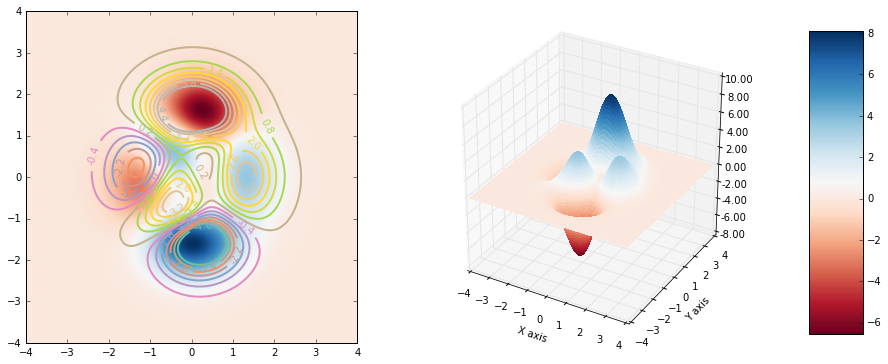

In [292]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z,cmap=cm.RdBu,extent=(-4,4,-4,4)) # drawing the function
#.xlabel('X Axis')
#axes[0][0].ylabel('Y Axis')
# adding the Contour lines with labels
cset = contour(Z,arange(-4,4.5,0.6),linewidths=2,cmap=cm.Set2,extent=(-4,4,-4,4))
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#colorbar(ax) # adding the colobar on the right
#ax.title('peaks function')
#axes[0][0].show()
ax2 = fig.add_subplot(1, 2, 2,projection='3d')
surf = ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')

#cbar_ax = colorbar(surf, shrink=0.5, aspect=3)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(surf, cax=cbar_ax)

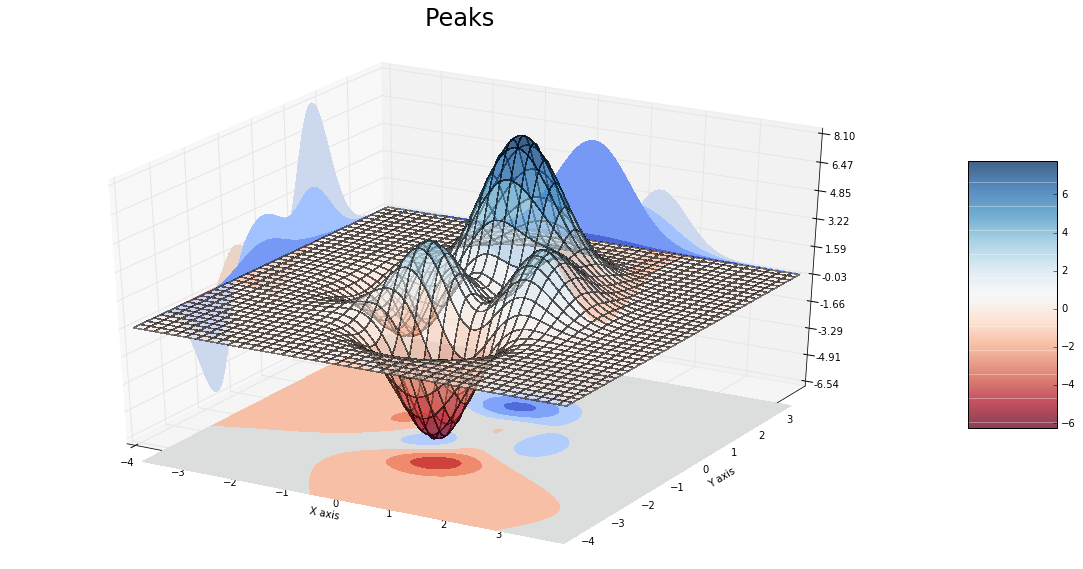

In [293]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.5,
                      cmap=cm.RdBu,linewidth=0.5, antialiased=False)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-8, cmap=cm.coolwarm_r)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-4, cmap=cm.coolwarm_r)
cset = ax.contourf(X, Y, Z, zdir='y', offset=4, cmap=cm.coolwarm_r)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
#ax.view_init(30, 40)

fig.colorbar(surf, shrink=0.5, aspect=3)
plt.title('Peaks',fontsize = 24,y = 1.08)
plt.tight_layout()
plt.show()


In [294]:
# Test Nelder-Mead
x0 = [-1,0] # other min use x0 = [0,-1]
ps = [x0]
method = 'Nelder-Mead'
start_time = time()
result = minimize(z_fun, x0, method=method, tol=1e-6,callback=reporter)
end_time = time()

print method+" took %f milliseconds" % (float(end_time - start_time)*1000.0)
print "and found a min of", z_fun(result.x)," at ",result.x,"\n"


Nelder-Mead took 5.527020 milliseconds
and found a min of -3.04701622207  at  [-1.34751524  0.20461296] 



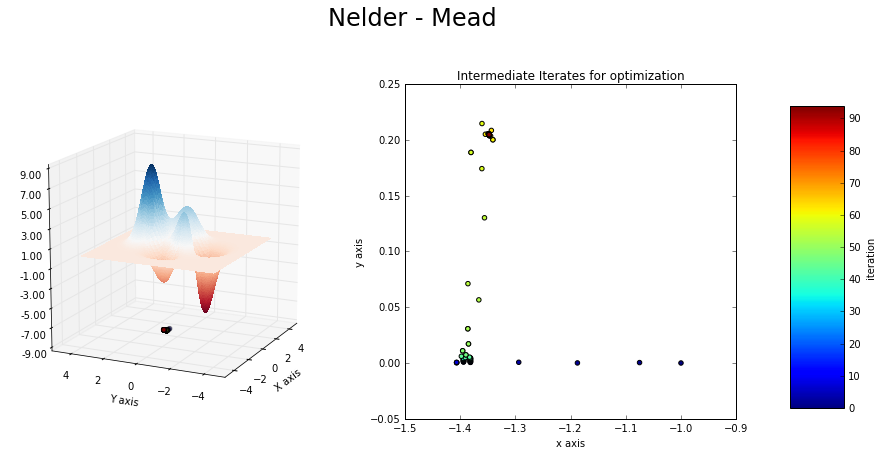

In [295]:
ps = np.array(ps)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1,projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

t = np.arange(len(ps))
ax.scatter(ps[:,0], ps[:,1], [-8.0]*len(ps),c=t)
ax.view_init(15, 205)
#fig.colorbar(surf, shrink=0.5, aspect=3)

ax2 = fig.add_subplot(1, 2, 2)
# Blue to red
scat = ax2.scatter(ps[:,0], ps[:,1],c=t)
ax2.set_xlabel("x axis")
ax2.set_ylabel("y axis")
ax2.set_title("Intermediate Iterates for optimization")
#cbar = plt.colorbar(ax2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(scat, cax=cbar_ax)
cbar.set_label('iteration')
fig.suptitle('Nelder - Mead',fontsize=24,y=1.08)

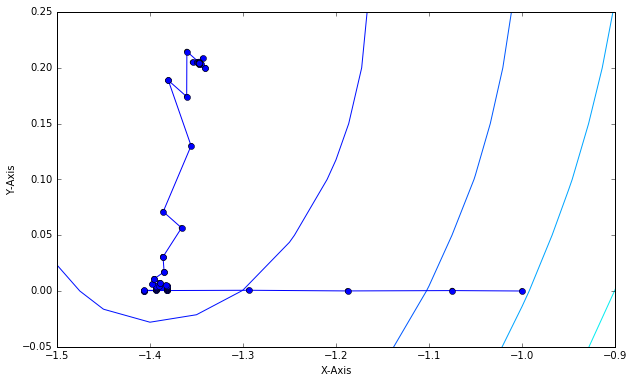

In [296]:
plt.figure(figsize=(10,6))
t = arange(len(ps))
plt.scatter(ps[:,0], ps[:,1],c=t)
plt.contour(X, Y, Z, arange(-4,4.5,0.6))
plt.plot(ps[:, 0], ps[:, 1],'-o')
plt.xlim([-1.5,-0.9])
plt.ylim([-0.05,0.25])
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")

In [297]:
########################
# Differential Evolution
ps = [x0]
bounds = [(-4,4), (-4, 4)] 
start_time = time()
result = differential_evolution(z_fun, bounds,callback=DE_reporter)
end_time = time()
print "Differential Evolution took %f milliseconds" % (float(end_time - start_time)*1000.0)
print "and found a min of", z_fun(result.x)," at ",result.x,"\n"


Differential Evolution took 31.758070 milliseconds
and found a min of -6.55108083978  at  [ 0.22828696 -1.62554064] 



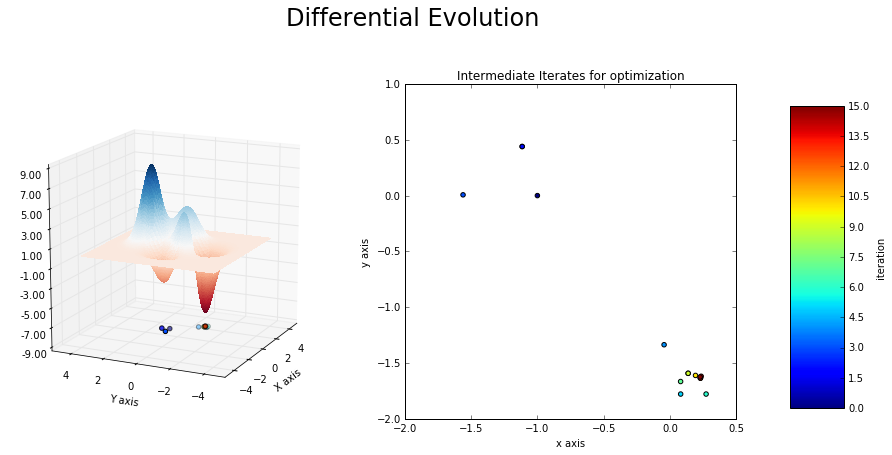

In [298]:

ps = np.array(ps)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1,projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

t = np.arange(len(ps))
ax.scatter(ps[:,0], ps[:,1], [-8.0]*len(ps),c=t)
ax.view_init(15, 205)
#fig.colorbar(surf, shrink=0.5, aspect=3)

ax2 = fig.add_subplot(1, 2, 2)
# Blue to red
scat = ax2.scatter(ps[:,0], ps[:,1],c=t)
ax2.set_xlabel("x axis")
ax2.set_ylabel("y axis")
ax2.set_title("Intermediate Iterates for optimization")
#cbar = plt.colorbar(ax2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(scat, cax=cbar_ax)
cbar.set_label('iteration')
#fig.tight_layout()
fig.suptitle('Differential Evolution',fontsize=24,y=1.08)


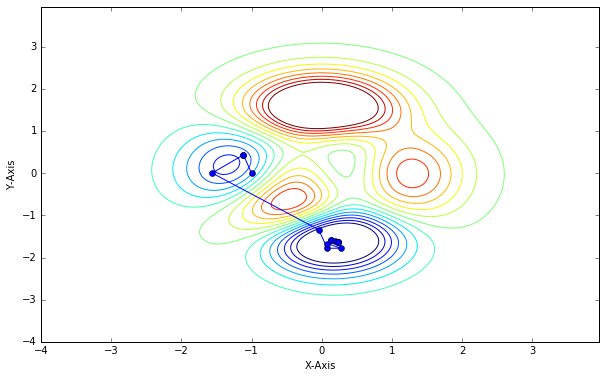

In [299]:
plt.figure(figsize=(10,6))
plt.contour(X, Y, Z, arange(-4,4.5,0.6))
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")

In [300]:
########################
# Basin hopping
ps = [x0]
minimizer_kwargs = {"method":method}
start_time = time()
result = basinhopping(z_fun, x0, minimizer_kwargs=minimizer_kwargs,callback=basin_reporter,niter=500)
end_time = time()
print "Basinhopping with "+method+" took %f milliseconds" % (float(end_time - start_time)*1000.0) 
print "and found a min of", z_fun(result.x)," at ",result.x,"\n"




Basinhopping with Nelder-Mead took 1156.633854 milliseconds
and found a min of -6.5510808372  at  [ 0.22830108 -1.62553534] 



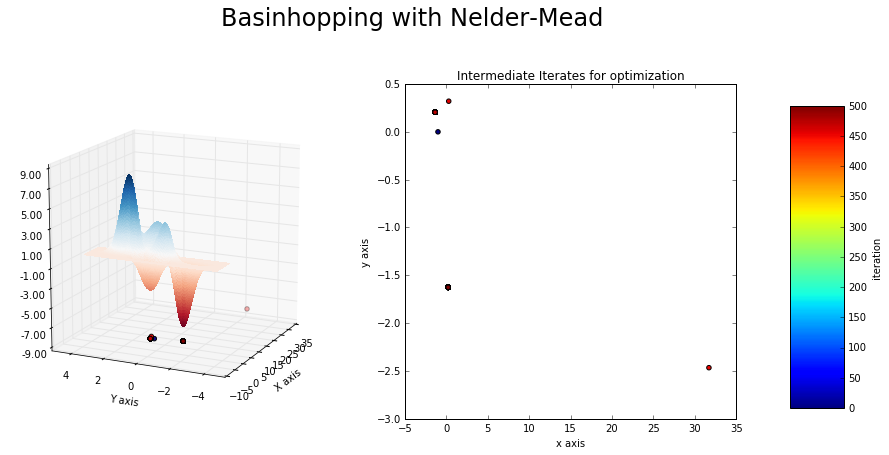

In [301]:
ps = np.array(ps)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1,projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

t = np.arange(len(ps))
ax.scatter(ps[:,0], ps[:,1], [-8.0]*len(ps),c=t)
ax.view_init(15, 205)
#fig.colorbar(surf, shrink=0.5, aspect=3)

ax2 = fig.add_subplot(1, 2, 2)
# Blue to red
scat = ax2.scatter(ps[:,0], ps[:,1],c=t)
# Add some axis labels.
ax2.set_xlabel("x axis")
ax2.set_ylabel("y axis")
ax2.set_title("Intermediate Iterates for optimization")
#cbar = plt.colorbar(ax2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(scat, cax=cbar_ax)
cbar.set_label('iteration')
#fig.tight_layout()
fig.suptitle('Basinhopping with Nelder-Mead',fontsize=24,y=1.08)

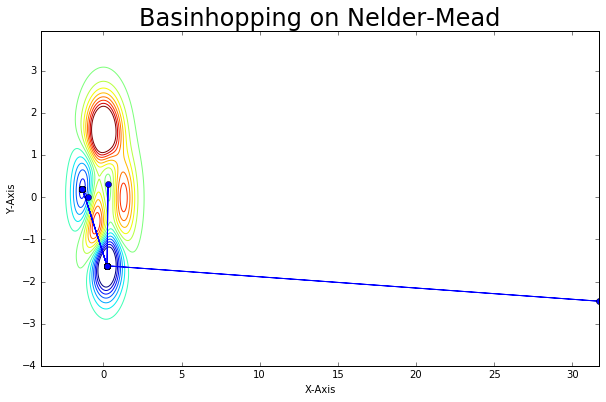

In [302]:
plt.figure(figsize=(10,6))
plt.contour(X, Y, Z, arange(-4,4.5,0.6))
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title('Basinhopping on Nelder-Mead',fontsize=24)

# Floor example

This function is not differentiable and has local optima all over the place. We can take a look at how the algorithms perform on this bizarre function.

In [318]:
# floor example
def z_fun_floor(x):
    func = np.floor(10*(10 - np.exp(-x[0]**2 - 3.0*x[1]**2)))/10.0
    return func
# for surface plots
x = arange(-1.0,1.0,0.025)
y = arange(-1.0,1.0,0.025)
X,Y = meshgrid(x, y) # grid of point
Z = z_fun_floor([X, Y])

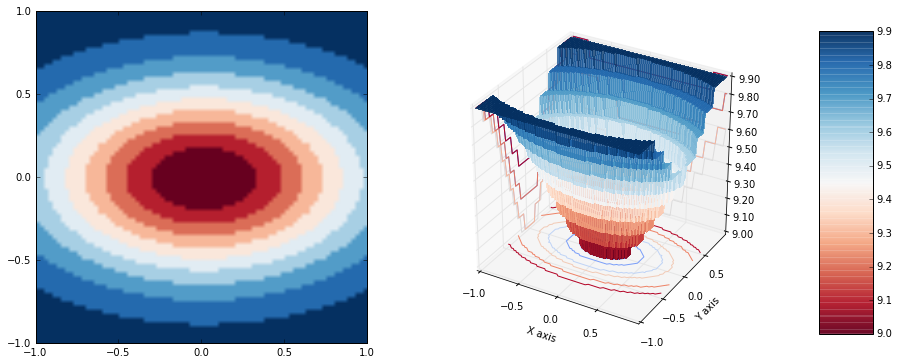

In [319]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z,cmap=cm.RdBu,extent=(-1,1,-1,1)) # drawing the function
#.xlabel('X Axis')
#axes[0][0].ylabel('Y Axis')
# adding the Contour lines with labels
cset = contour(Z,arange(-4,4.5,0.6),linewidths=2,cmap=cm.Set2,extent=(-1,1,-1,1))
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#colorbar(ax) # adding the colobar on the right
#ax.title('peaks function')
#axes[0][0].show()
ax2 = fig.add_subplot(1, 2, 2,projection='3d')
surf = ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.8, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)
cset = ax2.contour(X, Y, Z, zdir='z', offset=9, cmap=cm.coolwarm)
cset = ax2.contour(X, Y, Z, zdir='x', offset=-1, cmap=cm.coolwarm)
cset = ax2.contour(X, Y, Z, zdir='y', offset=1, cmap=cm.coolwarm)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')

#cbar_ax = colorbar(surf, shrink=0.5, aspect=3)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(surf, cax=cbar_ax)

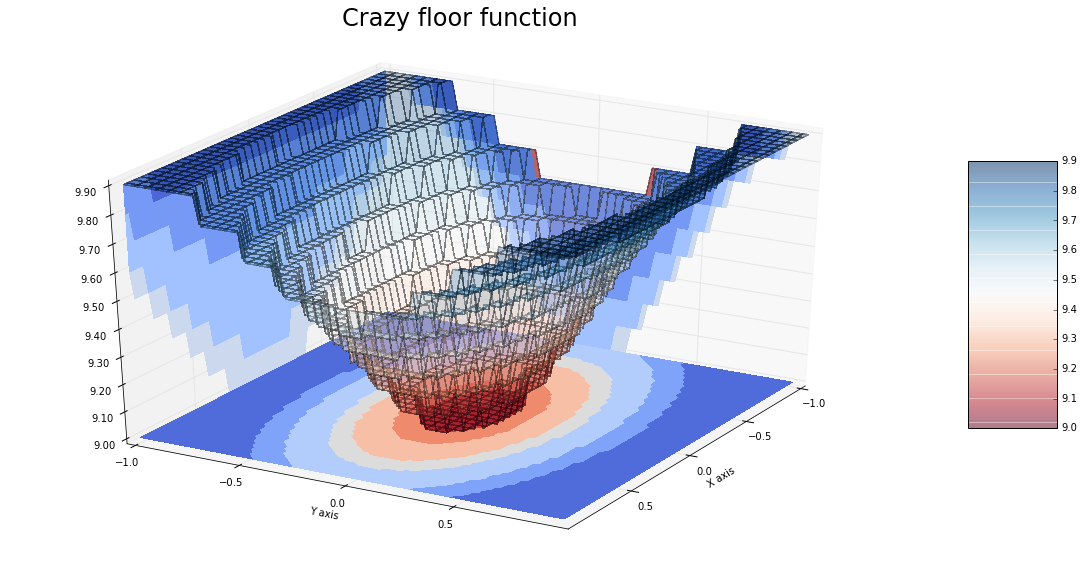

In [320]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2, alpha=0.3,
                      cmap=cm.RdBu,linewidth=0.5, antialiased=False)
cset = ax.contourf(X, Y, Z, zdir='z', offset=9, cmap=cm.coolwarm_r)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-1, cmap=cm.coolwarm_r)
cset = ax.contourf(X, Y, Z, zdir='y', offset=-1, cmap=cm.coolwarm_r)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.view_init(30, 30)

fig.colorbar(surf, shrink=0.5, aspect=3)
plt.title('Crazy floor function',fontsize = 24,y = 1.08)
plt.tight_layout()
plt.show()


In [321]:
# Test Nelder-Mead
x0 = [0.0,0.5] # other min use x0 = [0,-1]
ps = [x0]
method = 'Nelder-Mead'
start_time = time()
result = minimize(z_fun_floor, x0, method=method, tol=1e-9,callback=reporter)
end_time = time()

print method+" took %f milliseconds" % (float(end_time - start_time)*1000.0)
print "and found a min of", z_fun_floor(result.x)," at ",result.x,"\n"


Nelder-Mead took 1.840115 milliseconds
and found a min of 9.4  at  [  2.50000000e-04   4.75000000e-01] 



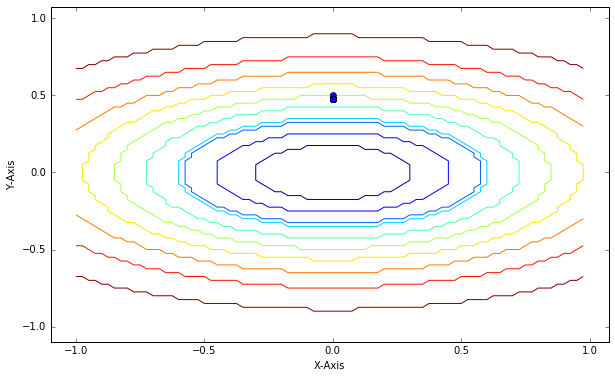

In [322]:
ps = np.array(ps)
plt.figure(figsize=(10,6))
t = arange(len(ps))
plt.scatter(ps[:,0], ps[:,1],c=t)
plt.contour(X, Y, Z, arange(9.0,10.0,0.1))
plt.plot(ps[:, 0], ps[:, 1],'-o')
#plt.xlim([-0.05,0.05])
#plt.ylim([0.32,0.36])
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")

In [323]:
########################
# Differential Evolution
ps = [x0]
bounds = [(-1,1), (-1, 1)] 
start_time = time()
result = differential_evolution(z_fun_floor, bounds,callback=DE_reporter)
end_time = time()
print "Differential Evolution took %f milliseconds" % (float(end_time - start_time)*1000.0)
print "and found a min of", z_fun_floor(result.x)," at ",result.x,"\n"


Differential Evolution took 6.748915 milliseconds
and found a min of 9.0  at  [-0.1444692  -0.15777445] 



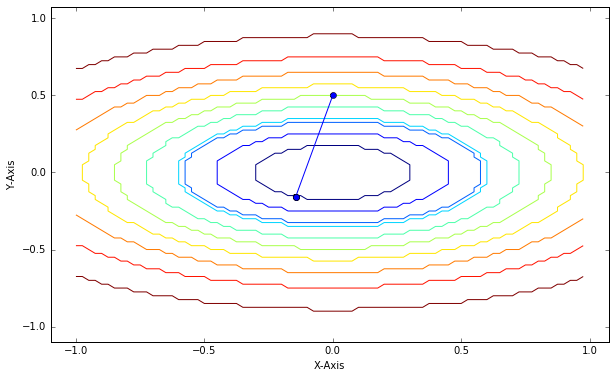

In [324]:
ps = np.array(ps)
plt.figure(figsize=(10,6))
t = arange(len(ps))
plt.scatter(ps[:,0], ps[:,1],c=t)
plt.contour(X, Y, Z, arange(9.0,10.0,0.1))
plt.plot(ps[:, 0], ps[:, 1],'-o')
#plt.xlim([-0.05,0.05])
#plt.ylim([0.32,0.36])
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")

In [325]:
########################
# Basin hopping
ps = [x0]
minimizer_kwargs = {"method":method}
start_time = time()
result = basinhopping(z_fun_floor, x0, minimizer_kwargs=minimizer_kwargs,callback=basin_reporter,niter=500)
end_time = time()
print "Basinhopping with "+method+" took %f milliseconds" % (float(end_time - start_time)*1000.0) 
print "and found a min of", z_fun_floor(result.x)," at ",result.x,"\n"




Basinhopping with Nelder-Mead took 380.485058 milliseconds
and found a min of 9.0  at  [-0.08167664 -0.14766788] 



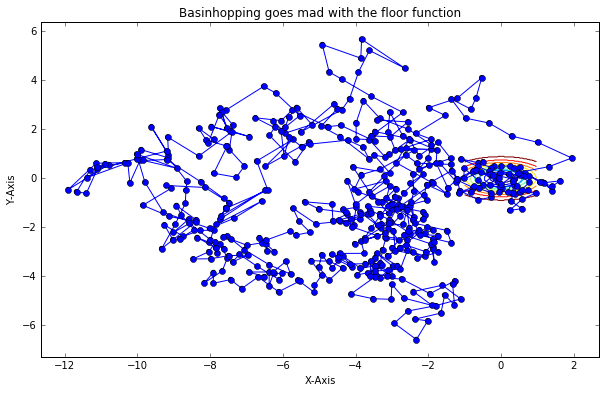

In [327]:
ps = np.array(ps)
plt.figure(figsize=(10,6))
t = arange(len(ps))
plt.plot(ps[:, 0], ps[:, 1],'-o')
plt.scatter(ps[:,0], ps[:,1],c=t)
plt.contour(X, Y, Z, arange(9.0,10.0,0.1))
#plt.xlim([-0.05,0.05])
#plt.ylim([0.32,0.36])
plt.title('Basinhopping goes mad with the floor function')
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")